In [1]:
%load_ext autoreload
%autoreload 2
from volpick.model.models import phase_dict #EventTypeDetectionLabeller
from volpick.model.augmentations import MyDuplicateEvent,SuperimposeEvent
import seisbench.data as sbd
import seisbench.generate as sbg
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
import numpy as np

from obspy.signal.trigger import trigger_onset

from scipy import signal
from obspy import Stream,Trace

In [2]:
def get_picks_from_prob(prob, threshold):
    triggers = trigger_onset(prob, thres1=threshold, thres2=threshold / 2.0)
    scores = []
    picks = []
    # get picks from annotations
    for s0, s1 in triggers:
        peak_value = np.max(prob[s0 : s1 + 1])
        idx_peak = s0 + np.argmax(prob[s0 : s1 + 1])
        scores.append(peak_value)
        picks.append(idx_peak)
    return np.array(scores), np.array(picks)

In [173]:
def get_waveform_and_picks(waveform_generator, idx):
    state_dict = waveform_generator._populate_state_dict(idx)
    for func in waveform_generator._augmentations:
        func(state_dict)
    p_pick = state_dict["X"][1]["trace_p_arrival_sample"] / 100
    s_pick = state_dict["X"][1]["trace_s_arrival_sample"] / 100
    starttime = state_dict["X"][1]["trace_start_time"]
    station = (
        state_dict["X"][1]["station_network_code"]
        + "."
        + state_dict["X"][1]["station_code"]
        + "."
        + state_dict["X"][1]["trace_channel"]
    )
    sample = waveform_generator._clean_state_dict(state_dict)
    return p_pick, s_pick, sample, starttime, station

In [3]:
def array2stream(a, component_order="ZNE"):
    trs = []
    for i in range(3):
        tr = Trace(
            data=a[0, :], header={"sampling_rate": 100, "channel": component_order[i]}
        )
        trs.append(tr)
    st = Stream(trs)
    return st

In [4]:
cm = 1 / 2.54
fts = 8
sos = signal.butter(4, [2, 20], "bandpass", analog=False, fs=100, output="sos")

In [5]:
component_order = "ZNE"

# Data

In [6]:
# data_path = "/mnt/DATA2/YiyuanZhong/my_datasets_seisbench/vcseis_my_noise"
data_path = "/mnt/DATA2/YiyuanZhong/my_datasets_seisbench/vcseis"
data = sbd.WaveformDataset(
    Path(data_path),
    sampling_rate=100,
    component_order="ZNE",
    dimension_order="NCW",
    cache="full",
)
train_data = data.train()
train_data_eq = train_data.filter(train_data["source_type"] != "noise", inplace=False)
train_data_noise = train_data.filter(
    train_data["source_type"] == "noise", inplace=False
)

In [7]:
lp_data = train_data_eq.filter(train_data_eq["source_type"] == "lp", inplace=False)
rg_data = train_data_eq.filter(train_data_eq["source_type"] != "lp", inplace=False)

In [8]:
p_phases = [key for key, val in phase_dict.items() if val == "P"]
s_phases = [key for key, val in phase_dict.items() if val == "S"]

# lp_detection_labeller = EventTypeDetectionLabeller(source_type="lp",
#     p_phases=p_phases, s_phases=s_phases, key=("X", "lp_detections"),sigma=20
# )
# rg_detection_labeller = EventTypeDetectionLabeller(source_type="regular",
#     p_phases=p_phases, s_phases=s_phases, key=("X", "rg_detections"),sigma=20
# )
detection_labeller = sbg.DetectionLabeller(
    p_phases, s_phases=s_phases, key=("X", "detections")
)

(array([20065., 13579.,  9612.,  7429.,  5849.,  4693.,  3829.,  3204.,
         2642.,  2346.,  2047.,  1829.,  1551.,  1398.,  1274.,  1165.,
         1035.,   965.,   870.,   746.,   706.,   652.,   602.,   602.,
          533.,   451.,   454.,   444.,   417.,   410.,   354.,   351.,
          314.,   298.,   258.,   281.,   256.,   234.,   235.,   233.,
          238.,   210.,   204.,   212.,   199.,   192.,   143.,   160.,
          149.,   147.,   134.,   162.,   154.,   146.,   122.,   123.,
          114.,   114.,    99.,   106.,   129.,   109.,   112.,    96.,
          110.,    82.,    82.,    70.,    80.,    77.,    79.,    63.,
           90.,    90.,    61.,    54.,    81.,    62.,    50.,    64.,
           56.,    54.,    66.,    67.,    58.,    58.,    45.,    50.,
           58.,    62.,    43.,    56.,    49.,    32.,    50.,    51.,
           50.,    30.,    51.,    32.]),
 array([0.02000001, 0.02479661, 0.0295932 , 0.0343898 , 0.03918639,
        0.04398298, 0.0487

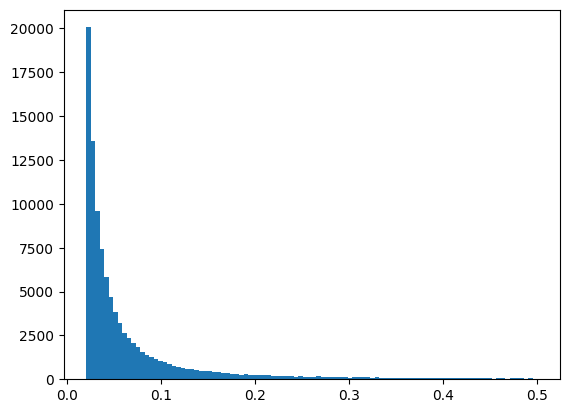

In [2]:
inv_scale = (2, 50)
y = []
for i in range(100000):
    scale = 1 / np.random.uniform(*inv_scale)
    y.append(scale)
y = np.array(y)
plt.hist(y, bins=100, log=False, cumulative=False)

(array([13957., 10753.,  8569.,  6869.,  5694.,  4821.,  4105.,  3565.,
         3014.,  2745.,  2417.,  2139.,  1914.,  1727.,  1588.,  1450.,
         1313.,  1170.,  1094.,  1090.,   994.,   864.,   818.,   782.,
          702.,   683.,   649.,   595.,   578.,   517.,   515.,   533.,
          431.,   409.,   429.,   413.,   370.,   396.,   343.,   313.,
          336.,   322.,   298.,   286.,   277.,   237.,   275.,   228.,
          226.,   229.,   238.,   222.,   197.,   197.,   187.,   203.,
          185.,   183.,   176.,   172.,   174.,   166.,   169.,   123.,
          142.,   159.,   131.,   134.,   128.,    96.,   110.,   118.,
          132.,    91.,   115.,   103.,   101.,    78.,    95.,   104.,
          107.,    76.,    73.,    90.,    96.,    81.,    80.,    91.,
           90.,    71.,    73.,    65.,    79.,    76.,    69.,    57.,
           65.,    63.,    66.,    61.]),
 array([0.25000708, 0.28750597, 0.32500487, 0.36250376, 0.40000265,
        0.43750155, 0.4750

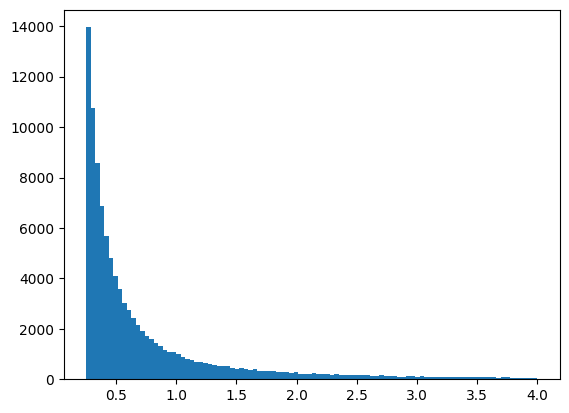

In [5]:
inv_scale = (0.25, 4)
y = []
for i in range(100000):
    scale = 1 / np.random.uniform(*inv_scale)
    y.append(scale)
y = np.array(y)
plt.hist(y, bins=100, log=False, cumulative=False)

# Normalization

In [10]:
norm_block1 = [
    # In 2/3 of the cases, select windows around picks, to reduce amount of noise traces in training.
    # Uses strategy variable, as padding will be handled by the random window.
    # In 1/3 of the cases, just returns the original trace, to keep diversity high.
    sbg.WindowAroundSample(
        list(phase_dict.keys()),
        samples_before=1000,
        windowlen=3000,
        selection="first",
        strategy="pad",
    ),
    # sbg.RandomWindow(
    #     low=None,
    #     high=None,
    #     windowlen=1500,
    #     strategy="pad",
    # ),
    sbg.ProbabilisticLabeller(
        label_columns=phase_dict, sigma=20, dim=0, shape="gaussian", noise_column=False
    ),
    detection_labeller,
    # lp_detection_labeller,
    # rg_detection_labeller,
    # Normalize to ensure correct augmentation behavior
    sbg.Normalize(
        detrend_axis=-1, amp_norm_axis=-1, amp_norm_type="peak", key=("X", "Xo")
    ),  # "peak"/“std
]

In [11]:
norm_gen_lp = sbg.GenericGenerator(lp_data)
norm_gen_rg = sbg.GenericGenerator(rg_data)
norm_gen_lp.add_augmentations(norm_block1)
norm_gen_rg.add_augmentations(norm_block1)

,index,source_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_depth_km,source_magnitude,source_magnitude_type,source_type,station_network_code,...,trace_s_status,trace_snr_db,trace_mean_snr_db,trace_frequency_index,split,trace_name_original,source_frequency_index,source_active_volcano_distance_m,trace_chunk,trace_component_order
7,7,alk61735213,1998-01-24T00:04:53.000000Z,54.730000,-163.929333,34.80,1.8,ml,lp,AV,...,NaN,"[9.249566747902742, nan, nan]",9.249567,-0.397179,train,alk61735213_AV.SSLS..EH.mseed,-0.397179,3902.600561,_ak_lp,ZNE
27,27,alk61741978,1998-06-06T10:13:32.820000Z,55.535000,-162.166167,23.15,1.9,ml,lp,AV,...,NaN,"[13.362016232738792, nan, nan]",13.362016,-0.748126,train,alk61741978_AV.PN7A..EH.mseed,-1.145334,21646.089285,_ak_lp,ZNE
28,28,alk61741978,1998-06-06T10:13:32.820000Z,55.535000,-162.166167,23.15,1.9,ml,lp,AV,...,NaN,"[26.272110865993014, 32.385081519353925, 31.76...",30.141550,-1.542543,train,alk61741978_AV.PV6..EH.mseed,-1.145334,21646.089285,_ak_lp,ZNE
38,38,alk61743408,1998-07-06T04:33:37.560000Z,54.701000,-164.184000,11.76,1.0,ml,lp,AV,...,NaN,"[12.089068815760264, nan, nan]",12.089069,-0.464695,train,alk61743408_AV.SSLS..EH.mseed,-0.464695,11423.170634,_ak_lp,ZNE
42,42,alk61743948,1998-07-14T21:11:52.120000Z,54.777500,-164.140500,14.62,1.2,ml,lp,AV,...,NaN,"[11.094685981257925, nan, nan]",11.094686,-1.124042,train,alk61743948_AV.ISTK..EH.mseed,-0.768267,11177.576924,_ak_lp,ZNE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231552,82576,J230627193749293515991331574,2023-06-27T19:37:49.290000Z,35.266500,133.262333,29.82,0.7,V,lp,NaN,...,NaN,"[0.3379038947220587, -0.48285151590191433, 3.4...",1.097070,-0.731079,train,J230627193749293515991331574_N.YSDH.mseed,-0.680433,59989.932640,_japan_vol_lp,ZNE
231553,82577,J230627193749293515991331574,2023-06-27T19:37:49.290000Z,35.266500,133.262333,29.82,0.7,V,lp,NaN,...,NaN,"[4.321491539023525, 6.474487100876422, -0.0779...",3.572670,-0.473231,train,J230627193749293515991331574_N.HINH.mseed,-0.680433,59989.932640,_japan_vol_lp,ZNE
231555,82579,J230627193749293515991331574,2023-06-27T19:37:49.290000Z,35.266500,133.262333,29.82,0.7,V,lp,NaN,...,NaN,"[8.023079538850762, 13.789222068325437, 9.1628...",10.325044,-0.687194,train,J230627193749293515991331574_N.TTAH.mseed,-0.680433,59989.932640,_japan_vol_lp,ZNE
231557,82581,J230628142303724249701411720,2023-06-28T14:23:03.720000Z,42.828333,141.286667,28.54,0.7,V,lp,NaN,...,NaN,"[6.617064884533636, 6.87958872011687, 7.094960...",6.863872,-0.953802,train,J230628142303724249701411720_ENIWA.mseed,-0.699466,3889.775937,_japan_vol_lp,ZNE


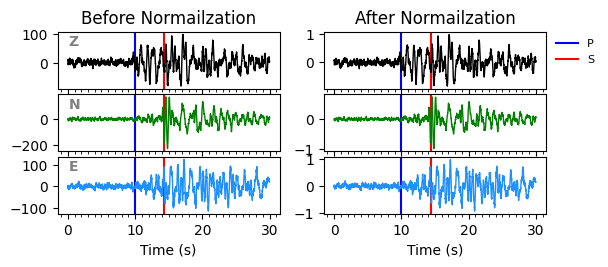

In [12]:
wcolors = ["black", "green", "dodgerblue"]

sample = norm_gen_lp[100]
fig, axs = plt.subplots(3, 2, figsize=(16 * cm, 6 * cm), sharex="all")
plt.subplots_adjust(hspace=0.1)

X_in_key = "X"
X_out_key = "Xo"

for i in reversed(range(3)):
    ax = axs[i][0]
    p_picks = get_picks_from_prob(sample["y"][0, :], 0.5)
    s_picks = get_picks_from_prob(sample["y"][1, :], 0.5)
    for p_pick in p_picks[1]:
        ax.axvline(p_pick / 100, color="blue")
    for s_pick in s_picks[1]:
        ax.axvline(s_pick / 100, color="red")
    ax.plot(
        np.arange(len(sample[X_in_key][i, :])) / 100,
        sample[X_in_key][i, :],
        color=wcolors[i],
        # label=component_order[i],
        lw=1,
    )

    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    # ax.set_ylabel(component_order[i])
    ax.text(
        0.05,
        0.95,
        component_order[i],
        ha="left",
        va="top",
        transform=ax.transAxes,
        weight="bold",
        color="gray",
    )

for i in reversed(range(3)):
    ax = axs[i][1]
    p_picks = get_picks_from_prob(sample["y"][0, :], 0.5)
    s_picks = get_picks_from_prob(sample["y"][1, :], 0.5)
    for p_pick in p_picks[1]:
        ax.axvline(p_pick / 100, color="blue", label="P")
    for s_pick in s_picks[1]:
        ax.axvline(s_pick / 100, color="red", label="S")

    ax.plot(
        np.arange(len(sample[X_out_key][i, :])) / 100,
        sample[X_out_key][i, :],
        color=wcolors[i],
        # label=component_order[i],
        lw=1,
    )

    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
axs[0][1].legend(
    loc="upper left", bbox_to_anchor=(1.0, 0.55, 0.2, 0.5), frameon=False, fontsize=fts
)
for i in range(2):
    axs[-1][i].set_xlabel("Time (s)")
axs[0][0].set_title("Before Normailzation")
axs[0][1].set_title("After Normailzation")
plt.savefig(
    "normalization.pdf",
    dpi=600,
    bbox_inches="tight",
)

In [ ]:
dat

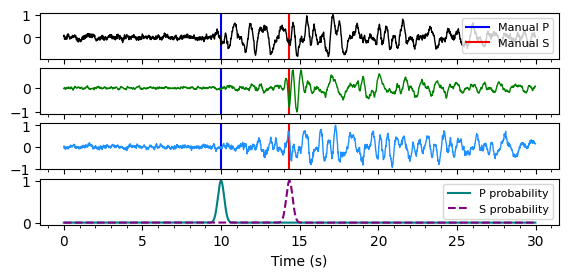

In [13]:
wcolors = ["black", "green", "dodgerblue"]

sample = norm_gen_lp[100]
fig, axs = plt.subplots(4, 1, figsize=(17 * cm, 7 * cm), sharex="all")
plt.subplots_adjust(hspace=0.2)

X_in_key = "X"
X_out_key = "Xo"

for i in reversed(range(3)):
    ax = axs[i]
    p_picks = get_picks_from_prob(sample["y"][0, :], 0.5)
    s_picks = get_picks_from_prob(sample["y"][1, :], 0.5)
    for p_pick in p_picks[1]:
        ax.axvline(p_pick / 100, color="blue", label="Manual P")
    for s_pick in s_picks[1]:
        ax.axvline(s_pick / 100, color="red", label="Manual S")

    ax.plot(
        np.arange(len(sample[X_out_key][i, :])) / 100,
        sample[X_out_key][i, :],
        color=wcolors[i],
        # label=component_order[i],
        lw=1,
    )
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
axs[0].legend(fontsize=fts)

labels = ["P probability", "S probability"]
colors = ["teal", "purple"]
lss = ["-", "--"]
for i in range(2):
    axs[3].plot(
        np.arange(len(sample["y"][i, :])) / 100,
        sample["y"][i, :],
        lss[i],
        color=colors[i],
        label=labels[i],
    )
axs[3].legend(fontsize=fts)

axs[-1].set_xlabel("Time (s)")
plt.savefig("labeling.pdf", dpi=600, bbox_inches="tight", pad_inches=0)

# LP and VT

In [251]:
illustrate_block1 = [
    # In 2/3 of the cases, select windows around picks, to reduce amount of noise traces in training.
    # Uses strategy variable, as padding will be handled by the random window.
    # In 1/3 of the cases, just returns the original trace, to keep diversity high.
    sbg.WindowAroundSample(
        list(phase_dict.keys()),
        samples_before=500,
        windowlen=2000,
        selection="first",
        strategy="pad",
    ),
    # sbg.RandomWindow(
    #     low=None,
    #     high=None,
    #     windowlen=1500,
    #     strategy="pad",
    # ),
    sbg.ProbabilisticLabeller(
        label_columns=phase_dict, sigma=20, dim=0, shape="gaussian", noise_column=False
    ),
    detection_labeller,
    # lp_detection_labeller,
    # rg_detection_labeller,
    # Normalize to ensure correct augmentation behavior
    sbg.Normalize(
        detrend_axis=-1, amp_norm_axis=-1, amp_norm_type="peak", key=("X", "Xo")
    ),  # "peak"/“std
]
illustrate_gen_lp = sbg.GenericGenerator(lp_data)
illustrate_gen_rg = sbg.GenericGenerator(rg_data)
illustrate_gen_lp.add_augmentations(illustrate_block1)
illustrate_gen_rg.add_augmentations(illustrate_block1)

In [44]:
lp_data.metadata

,index,source_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_depth_km,source_magnitude,source_magnitude_type,source_type,station_network_code,...,trace_s_status,trace_snr_db,trace_mean_snr_db,trace_frequency_index,split,trace_name_original,source_frequency_index,source_active_volcano_distance_m,trace_chunk,trace_component_order
0,0,alk61731378,1997-11-07T13:50:12.150000Z,60.043500,-153.073167,1.36,0.1,ml,lp,AV,...,NaN,"[8.089339552166457, nan, nan]",8.089340,-0.791209,train,alk61731378_AV.ILS..EH.mseed,-0.882456,1657.972277,_ak_lp,ZNE
1,1,alk61731378,1997-11-07T13:50:12.150000Z,60.043500,-153.073167,1.36,0.1,ml,lp,AV,...,NaN,"[12.314789945589508, 16.11889869690067, 9.4106...",12.614768,-0.973703,train,alk61731378_AV.IVE..EH.mseed,-0.882456,1657.972277,_ak_lp,ZNE
2,2,alk61732163,1997-11-25T04:38:49.980000Z,60.019667,-153.120000,1.25,-0.1,ml,lp,AV,...,NaN,"[19.0045297959485, 12.128193929878003, 14.4137...",15.182152,-0.821472,train,alk61732163_AV.IVE..EH.mseed,-0.821472,2080.833652,_ak_lp,ZNE
3,3,alk61732213,1997-11-26T21:22:44.070000Z,60.026000,-153.096667,0.61,0.4,ml,lp,AV,...,NaN,"[16.50637382103238, 5.883320034987504, 12.7329...",11.707556,-0.390263,train,alk61732213_AV.IVE..EH.mseed,-0.390263,711.129974,_ak_lp,ZNE
4,4,alk61732218,1997-11-26T21:24:32.230000Z,60.031833,-153.093000,-0.49,-0.1,ml,lp,AV,...,NaN,"[22.719516448098705, 10.604068714832064, 16.20...",16.510555,-0.281600,train,alk61732218_AV.IVE..EH.mseed,-0.281600,67.306677,_ak_lp,ZNE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231552,82576,J230627193749293515991331574,2023-06-27T19:37:49.290000Z,35.266500,133.262333,29.82,0.7,V,lp,NaN,...,NaN,"[0.3379038947220587, -0.48285151590191433, 3.4...",1.097070,-0.731079,train,J230627193749293515991331574_N.YSDH.mseed,-0.680433,59989.932640,_japan_vol_lp,ZNE
231553,82577,J230627193749293515991331574,2023-06-27T19:37:49.290000Z,35.266500,133.262333,29.82,0.7,V,lp,NaN,...,NaN,"[4.321491539023525, 6.474487100876422, -0.0779...",3.572670,-0.473231,train,J230627193749293515991331574_N.HINH.mseed,-0.680433,59989.932640,_japan_vol_lp,ZNE
231555,82579,J230627193749293515991331574,2023-06-27T19:37:49.290000Z,35.266500,133.262333,29.82,0.7,V,lp,NaN,...,NaN,"[8.023079538850762, 13.789222068325437, 9.1628...",10.325044,-0.687194,train,J230627193749293515991331574_N.TTAH.mseed,-0.680433,59989.932640,_japan_vol_lp,ZNE
231557,82581,J230628142303724249701411720,2023-06-28T14:23:03.720000Z,42.828333,141.286667,28.54,0.7,V,lp,NaN,...,NaN,"[6.617064884533636, 6.87958872011687, 7.094960...",6.863872,-0.953802,train,J230628142303724249701411720_ENIWA.mseed,-0.699466,3889.775937,_japan_vol_lp,ZNE


array([False, False, False, ...,  True,  True,  True])

In [72]:
dlp_indexes = np.asarray((lp_data.metadata["source_depth_km"] > 15).values).nonzero()
print(dlp_indexes)

(array([     7,     22,     23, ..., 128799, 128800, 128801]),)


In [96]:
dlp_indexes[0][3050]

29578

In [97]:
lp_data.metadata.iloc[29578]

index                                                                           34742
source_id                                                                 alk60156288
source_origin_time                                        2010-10-14T22:38:19.360000Z
source_latitude_deg                                                         56.873833
source_longitude_deg                                                      -158.042333
source_depth_km                                                                 19.31
source_magnitude                                                                  0.9
source_magnitude_type                                                              ml
source_type                                                                        lp
station_network_code                                                               AV
station_code                                                                     ANON
station_location_code                                 

In [98]:
norm_gen_lp._populate_state_dict(29578)["X"][1]

{'index': 34742,
 'source_id': 'alk60156288',
 'source_origin_time': '2010-10-14T22:38:19.360000Z',
 'source_latitude_deg': 56.87383333333333,
 'source_longitude_deg': -158.04233333333335,
 'source_depth_km': 19.31,
 'source_magnitude': 0.9,
 'source_magnitude_type': 'ml',
 'source_type': 'lp',
 'station_network_code': 'AV',
 'station_code': 'ANON',
 'station_location_code': '--',
 'trace_channel': 'EH',
 'station_latitude_deg': 56.919,
 'station_longitude_deg': -158.1737,
 'station_elevation_m': 445.0,
 'station_epicentral_distance_m': 9454.484557223584,
 'path_azimuth_deg': 302.1948621084733,
 'path_back_azimuth_deg': 122.08481825697837,
 'trace_p_arrival_time': '2010-10-14T22:38:23.100000Z',
 'trace_s_arrival_time': '2010-10-14T22:38:26.040000Z',
 'trace_p_max_weight': 1.0,
 'trace_s_max_weight': 1.0,
 'trace_p_first_motion': nan,
 'trace_name': 'bucket32$893,:3,:12292',
 'trace_sampling_rate_hz': 100.0,
 'trace_has_spikes': False,
 'trace_start_time': '2010-10-14T22:37:23.105200Z',

In [140]:
norm_gen_lp._populate_state_dict(29578)["X"][1]

{'index': 34742,
 'source_id': 'alk60156288',
 'source_origin_time': '2010-10-14T22:38:19.360000Z',
 'source_latitude_deg': 56.87383333333333,
 'source_longitude_deg': -158.04233333333335,
 'source_depth_km': 19.31,
 'source_magnitude': 0.9,
 'source_magnitude_type': 'ml',
 'source_type': 'lp',
 'station_network_code': 'AV',
 'station_code': 'ANON',
 'station_location_code': '--',
 'trace_channel': 'EH',
 'station_latitude_deg': 56.919,
 'station_longitude_deg': -158.1737,
 'station_elevation_m': 445.0,
 'station_epicentral_distance_m': 9454.484557223584,
 'path_azimuth_deg': 302.1948621084733,
 'path_back_azimuth_deg': 122.08481825697837,
 'trace_p_arrival_time': '2010-10-14T22:38:23.100000Z',
 'trace_s_arrival_time': '2010-10-14T22:38:26.040000Z',
 'trace_p_max_weight': 1.0,
 'trace_s_max_weight': 1.0,
 'trace_p_first_motion': nan,
 'trace_name': 'bucket32$893,:3,:12292',
 'trace_sampling_rate_hz': 100.0,
 'trace_has_spikes': False,
 'trace_start_time': '2010-10-14T22:37:23.105200Z',

In [254]:
dlp_indexes = np.asarray(
    (
        (lp_data.metadata["source_depth_km"] > 10)
        & (lp_data.metadata["station_code"] == "ANON")
    ).values
).nonzero()
dlp_indexes

(array([  622,   634, 11021, 11107, 14740, 14748, 14834, 14841, 14844,
        14847, 14852, 15336, 15646, 16395, 17642, 18403, 18420, 18425,
        18518, 18524, 18526, 18606, 18609, 18725, 18727, 18730, 19243,
        20531, 29578, 29890, 29894, 29897, 43784]),)

In [277]:
idx = 29578
print(norm_gen_lp._populate_state_dict(idx)["X"][1]["source_frequency_index"])
print(norm_gen_lp._populate_state_dict(idx)["X"][1]["source_depth_km"])

-1.0969359876059692
19.31


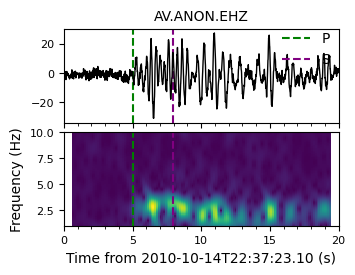

In [279]:
p_pick, s_pick, sample_lp, starttime, station = get_waveform_and_picks(
    illustrate_gen_lp, idx
)

plot_n_comp = 1
fig, axs = plt.subplots(plot_n_comp + 1, figsize=(9 * cm, 6.5 * cm), sharex="all")
plt.subplots_adjust(hspace=0.1)
wcolors = ["black", "green", "dodgerblue"]
X_in_key = "X"
X_out_key = "Xo"
for i in range(plot_n_comp):
    ax = axs[i]
    # ax.plot(sample_lp[X_out_key][i,:].T,color="blue",lw=0.5)
    # sample_lp[X_out_key][i, :] = signal.sosfilt(sos, sample_lp[X_out_key][i, :])
    ax.axvline(p_pick, color="green", ls="--", label="P")
    ax.axvline(s_pick, color="purple", ls="--", label="S")
    # for pred_p_pick in pred_p_picks[1]:
    #     ax.axvline(pred_p_pick / 100, color="blue")
    # for pred_s_pick in pred_s_picks[1]:
    #     ax.axvline(pred_s_pick / 100, color="red")
    ax.plot(
        np.arange(len(sample_lp[X_in_key][i, :])) / 100,
        sample_lp[X_in_key][i, :],
        color=wcolors[i],
        lw=1,
    )
    pred_p_picks = get_picks_from_prob(sample_lp["y"][0, :], 0.5)
    pred_s_picks = get_picks_from_prob(sample_lp["y"][1, :], 0.5)

    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    # ax.text(
    #     0.05,
    #     0.95,
    #     component_order[i],
    #     ha="left",
    #     va="top",
    #     transform=ax.transAxes,
    #     weight="bold",
    #     color="gray",
    # )
axs[0].legend(loc="upper left", bbox_to_anchor=(0.75, 0.65, 0.5, 0.45), frameon=False)
axs[0].set_title(f"{station}Z", fontsize=10)
# axs[0].set_ylim([-130, 130])

st = array2stream(sample_lp[X_in_key])
st[0].spectrogram(log=False, axes=axs[plot_n_comp])
axs[plot_n_comp].set_ylim([1, 10])
axs[plot_n_comp].axvline(p_pick, color="green", ls="--", label="P")
axs[plot_n_comp].axvline(s_pick, color="purple", ls="--", label="S")
axs[plot_n_comp].set_ylabel("Frequency (Hz)")
for i in range(plot_n_comp + 1):
    axs[i].tick_params(labelsize=fts)
axs[-1].set_xlabel(f"Time from {starttime[:-5]} (s)")
plt.savefig("An_LP_example.pdf", dpi=600, bbox_inches="tight", pad_inches=0)

In [164]:
vt_indexes = np.asarray(
    (
        (rg_data.metadata["station_code"] == "ANON")
        & (rg_data.metadata["source_depth_km"] > 0)
    ).values
).nonzero()
print(vt_indexes)

(array([ 2820,  7077,  8886, 13765, 15140, 15513, 15822, 28312, 40097,
       40958, 41757, 42099]),)


In [203]:
norm_gen_rg._populate_state_dict(13765)["X"][1]

{'index': 16245,
 'source_id': 'alk61880308',
 'source_origin_time': '2006-01-15T01:24:50.220000Z',
 'source_latitude_deg': 56.863166666666665,
 'source_longitude_deg': -158.176,
 'source_depth_km': 5.67,
 'source_magnitude': 0.9,
 'source_magnitude_type': 'ml',
 'source_type': 'le',
 'station_network_code': 'AV',
 'station_code': 'ANON',
 'station_location_code': '--',
 'trace_channel': 'EH',
 'station_latitude_deg': 56.919,
 'station_longitude_deg': -158.1737,
 'station_elevation_m': 445.0,
 'station_epicentral_distance_m': 6219.064158954383,
 'path_azimuth_deg': 1.2906520149169152,
 'path_back_azimuth_deg': 181.29257857270017,
 'trace_p_arrival_time': '2006-01-15T01:24:51.756667Z',
 'trace_s_arrival_time': '2006-01-15T01:24:53.490000Z',
 'trace_p_max_weight': 1.03,
 'trace_s_max_weight': 1.03,
 'trace_p_first_motion': nan,
 'trace_name': 'bucket14$382,:3,:12172',
 'trace_sampling_rate_hz': 100.0,
 'trace_has_spikes': False,
 'trace_start_time': '2006-01-15T01:23:51.761100Z',
 'trace

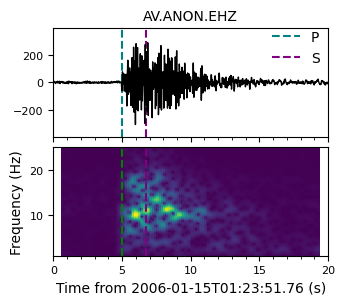

In [271]:
idx = 13765
p_pick, s_pick, sample_vt, starttime, station = get_waveform_and_picks(
    illustrate_gen_rg, idx
)

plot_n_comp = 1
fig, axs = plt.subplots(plot_n_comp + 1, figsize=(9 * cm, 7.5 * cm), sharex="all")
plt.subplots_adjust(hspace=0.1)
wcolors = ["black", "green", "dodgerblue"]
X_in_key = "X"
X_out_key = "Xo"
for i in range(plot_n_comp):
    ax = axs[i]
    # ax.plot(sample_vt[X_out_key][i,:].T,color="blue",lw=0.5)
    # sample_vt[X_out_key][i, :] = signal.sosfilt(sos, sample_vt[X_out_key][i, :])
    ax.axvline(p_pick, color="teal", ls="--", label="P")
    ax.axvline(s_pick, color="purple", ls="--", label="S")
    # for pred_p_pick in pred_p_picks[1]:
    #     ax.axvline(pred_p_pick / 100, color="blue")
    # for pred_s_pick in pred_s_picks[1]:
    #     ax.axvline(pred_s_pick / 100, color="red")
    ax.plot(
        np.arange(len(sample_vt[X_in_key][i, :])) / 100,
        sample_vt[X_in_key][i, :],
        color=wcolors[i],
        lw=1,
    )
    pred_p_picks = get_picks_from_prob(sample_vt["y"][0, :], 0.5)
    pred_s_picks = get_picks_from_prob(sample_vt["y"][1, :], 0.5)

    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    # ax.text(
    #     0.05,
    #     0.95,
    #     component_order[i],
    #     ha="left",
    #     va="top",
    #     transform=ax.transAxes,
    #     weight="bold",
    #     color="gray",
    # )
axs[0].legend(loc="upper left", bbox_to_anchor=(0.75, 0.65, 0.5, 0.45), frameon=False)
axs[0].set_title(f"{station}Z", fontsize=10)
axs[0].set_ylim([-390, 390])

st = array2stream(sample_vt[X_in_key])
st[0].spectrogram(log=False, axes=axs[plot_n_comp])
axs[plot_n_comp].set_ylim([1, 25])
axs[plot_n_comp].axvline(p_pick, color="green", ls="--", label="P")
axs[plot_n_comp].axvline(s_pick, color="purple", ls="--", label="S")
axs[plot_n_comp].set_ylabel("Frequency (Hz)")
for i in range(plot_n_comp + 1):
    axs[i].tick_params(labelsize=fts)
axs[-1].set_xlabel(f"Time from {starttime[:-5]} (s)")
plt.savefig("A_VT_example.pdf", dpi=600, bbox_inches="tight", pad_inches=0)

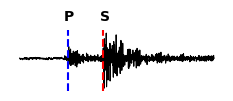

In [314]:
idx = 200
p_pick, s_pick, sample_vt, starttime, station = get_waveform_and_picks(
    illustrate_gen_rg, idx
)

plot_n_comp = 1
fig, axs = plt.subplots(plot_n_comp, figsize=(7 * cm, 2 * cm), sharex="all")
plt.subplots_adjust(hspace=0.1)
wcolors = ["black", "green", "dodgerblue"]
X_in_key = "X"
X_out_key = "Xo"
for i in range(plot_n_comp):
    ax = axs
    # ax.plot(sample_vt[X_out_key][i,:].T,color="blue",lw=0.5)
    # sample_vt[X_out_key][i, :] = signal.sosfilt(sos, sample_vt[X_out_key][i, :])

    # for pred_p_pick in pred_p_picks[1]:
    #     ax.axvline(pred_p_pick / 100, color="blue")
    # for pred_s_pick in pred_s_picks[1]:
    #     ax.axvline(pred_s_pick / 100, color="red")
    ax.plot(
        np.arange(len(sample_vt[X_in_key][i, :])) / 100,
        sample_vt[X_in_key][i, :],
        color=wcolors[i],
        lw=0.8,
    )
    ax.axvline(p_pick, color="blue", ls="--", label="P")
    ax.axvline(s_pick, color="red", ls="--", label="S")

    pred_p_picks = get_picks_from_prob(sample_vt["y"][0, :], 0.5)
    pred_s_picks = get_picks_from_prob(sample_vt["y"][1, :], 0.5)

    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
# axs.legend(
#     loc="upper left", bbox_to_anchor=(0.1, 0.95, 0.5, 0.45), frameon=False, ncols=2
# )
# axs.set_title(f"{station}Z", fontsize=10)
# axs[0].set_ylim([-390, 390])
ax.text(
    0.25,
    1.35,
    "P",
    ha="left",
    va="top",
    transform=ax.transAxes,
    weight="bold",
    # color="gray",
)
ax.text(
    0.42,
    1.35,
    "S",
    ha="left",
    va="top",
    transform=ax.transAxes,
    weight="bold",
    # color="gray",
)
axs.set_axis_off()

# st = array2stream(sample_vt[X_in_key])
# st[0].spectrogram(log=False, axes=axs[plot_n_comp])
# axs[plot_n_comp].set_ylim([1, 25])
# axs[plot_n_comp].axvline(p_pick, color="green", ls="--", label="P")
# axs[plot_n_comp].axvline(s_pick, color="purple", ls="--", label="S")
# axs[plot_n_comp].set_ylabel("Frequency (Hz)")
# for i in range(plot_n_comp + 1):
#     axs[i].tick_params(labelsize=fts)
axs.set_xlabel(f"Time from {starttime[:-5]} (s)")
plt.savefig("pick_illustration.pdf", dpi=600, bbox_inches="tight", pad_inches=0)

# Shifting

In [268]:
shift_block1 = [
    # In 2/3 of the cases, select windows around picks, to reduce amount of noise traces in training.
    # Uses strategy variable, as padding will be handled by the random window.
    # In 1/3 of the cases, just returns the original trace, to keep diversity high.
    sbg.WindowAroundSample(
        list(phase_dict.keys()),
        samples_before=3000,
        windowlen=6000,
        selection="first",
        strategy="pad",
    ),
    sbg.RandomWindow(
        low=None,
        high=None,
        windowlen=3000,
        strategy="pad",
    ),
    sbg.ProbabilisticLabeller(
        label_columns=phase_dict, sigma=20, dim=0, shape="gaussian", noise_column=False
    ),
    detection_labeller,
    # lp_detection_labeller,
    # rg_detection_labeller,
    # Normalize to ensure correct augmentation behavior
    sbg.Normalize(
        detrend_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"
    ),  # "peak"/“std
]

In [269]:
shift_gen_lp = sbg.GenericGenerator(lp_data)
shift_gen_rg = sbg.GenericGenerator(rg_data)
shift_gen_lp.add_augmentations(shift_block1)
shift_gen_rg.add_augmentations(shift_block1)

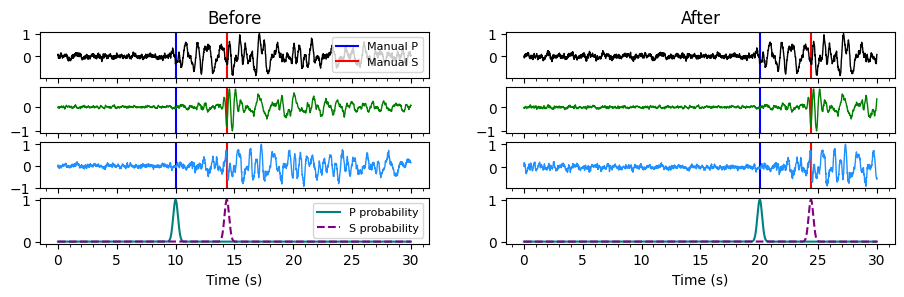

In [273]:
wcolors = ["black", "green", "dodgerblue"]

sample = norm_gen_lp[100]
fig, axs = plt.subplots(4, 2, figsize=(28 * cm, 7 * cm), sharex="all")
plt.subplots_adjust(hspace=0.2)

X_key = "X"
norm_X_key = "Xo"

for i in reversed(range(3)):
    ax = axs[i][0]
    p_picks = get_picks_from_prob(sample["y"][0, :], 0.5)
    s_picks = get_picks_from_prob(sample["y"][1, :], 0.5)
    for p_pick in p_picks[1]:
        ax.axvline(p_pick / 100, color="blue", label="Manual P")
    for s_pick in s_picks[1]:
        ax.axvline(s_pick / 100, color="red", label="Manual S")

    ax.plot(
        np.arange(len(sample[norm_X_key][i, :])) / 100,
        sample[norm_X_key][i, :],
        color=wcolors[i],
        # label=component_order[i],
        lw=1,
    )
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
axs[0][0].legend(fontsize=fts)

labels = ["P probability", "S probability"]
colors = ["teal", "purple"]
lss = ["-", "--"]
for i in range(2):
    axs[3][0].plot(
        np.arange(len(sample["y"][i, :])) / 100,
        sample["y"][i, :],
        lss[i],
        color=colors[i],
        label=labels[i],
    )
axs[3][0].legend(fontsize=fts)

#
sample = shift_gen_lp[100]
for i in reversed(range(3)):
    ax = axs[i][1]
    p_picks = get_picks_from_prob(sample["y"][0, :], 0.5)
    s_picks = get_picks_from_prob(sample["y"][1, :], 0.5)
    for p_pick in p_picks[1]:
        ax.axvline(p_pick / 100, color="blue", label="Manual P")
    for s_pick in s_picks[1]:
        ax.axvline(s_pick / 100, color="red", label="Manual S")

    ax.plot(
        np.arange(len(sample[X_key][i, :])) / 100,
        sample[X_key][i, :],
        color=wcolors[i],
        # label=component_order[i],
        lw=1,
    )
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
# axs[0][1].legend(fontsize=fts)

labels = ["P probability", "S probability"]
colors = ["teal", "purple"]
lss = ["-", "--"]
for i in range(2):
    axs[3][1].plot(
        np.arange(len(sample["y"][i, :])) / 100,
        sample["y"][i, :],
        lss[i],
        color=colors[i],
        label=labels[i],
    )
# axs[3][1].legend(fontsize=fts)

axs[0][0].set_title("Before")
axs[0][1].set_title("After")
for i in range(2):
    axs[-1][i].set_xlabel("Time (s)")
plt.savefig("shifting.pdf", dpi=600, bbox_inches="tight", pad_inches=0)

# Adding gaps

In [258]:
gap_block1 = [
    # In 2/3 of the cases, select windows around picks, to reduce amount of noise traces in training.
    # Uses strategy variable, as padding will be handled by the random window.
    # In 1/3 of the cases, just returns the original trace, to keep diversity high.
    sbg.WindowAroundSample(
        list(phase_dict.keys()),
        samples_before=1000,
        windowlen=3000,
        selection="first",
        strategy="pad",
    ),
    # sbg.RandomWindow(
    #     low=None,
    #     high=None,
    #     windowlen=3000,
    #     strategy="pad",
    # ),
    sbg.ProbabilisticLabeller(
        label_columns=phase_dict, sigma=20, dim=0, shape="gaussian", noise_column=False
    ),
    detection_labeller,
    # lp_detection_labeller,
    # rg_detection_labeller,
    # Normalize to ensure correct augmentation behavior
    sbg.AddGap(label_keys=["y", "detections"], noise_id={}),
    # sbg.AddGap(label_keys=["y", "detections"]),
    sbg.Normalize(
        detrend_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"
    ),  # "peak"/“std
]

In [259]:
gap_gen_lp = sbg.GenericGenerator(lp_data)
gap_gen_rg = sbg.GenericGenerator(rg_data)
gap_gen_lp.add_augmentations(gap_block1)
gap_gen_rg.add_augmentations(gap_block1)

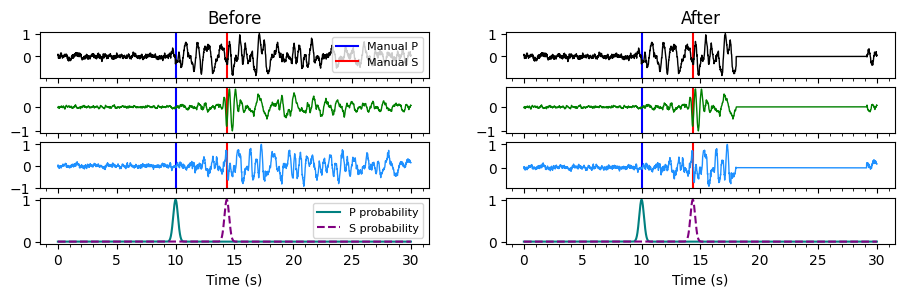

In [276]:
wcolors = ["black", "green", "dodgerblue"]

sample = norm_gen_lp[100]
fig, axs = plt.subplots(4, 2, figsize=(28 * cm, 7 * cm), sharex="all")
plt.subplots_adjust(hspace=0.2)

X_key = "X"
norm_X_key = "Xo"

for i in reversed(range(3)):
    ax = axs[i][0]
    p_picks = get_picks_from_prob(sample["y"][0, :], 0.5)
    s_picks = get_picks_from_prob(sample["y"][1, :], 0.5)
    for p_pick in p_picks[1]:
        ax.axvline(p_pick / 100, color="blue", label="Manual P")
    for s_pick in s_picks[1]:
        ax.axvline(s_pick / 100, color="red", label="Manual S")

    ax.plot(
        np.arange(len(sample[norm_X_key][i, :])) / 100,
        sample[norm_X_key][i, :],
        color=wcolors[i],
        # label=component_order[i],
        lw=1,
    )
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
axs[0][0].legend(fontsize=fts)

labels = ["P probability", "S probability"]
colors = ["teal", "purple"]
lss = ["-", "--"]
for i in range(2):
    axs[3][0].plot(
        np.arange(len(sample["y"][i, :])) / 100,
        sample["y"][i, :],
        lss[i],
        color=colors[i],
        label=labels[i],
    )
axs[3][0].legend(fontsize=fts)

#
sample = gap_gen_lp[100]
for i in reversed(range(3)):
    ax = axs[i][1]
    p_picks = get_picks_from_prob(sample["y"][0, :], 0.5)
    s_picks = get_picks_from_prob(sample["y"][1, :], 0.5)
    for p_pick in p_picks[1]:
        ax.axvline(p_pick / 100, color="blue", label="Manual P")
    for s_pick in s_picks[1]:
        ax.axvline(s_pick / 100, color="red", label="Manual S")

    ax.plot(
        np.arange(len(sample[X_key][i, :])) / 100,
        sample[X_key][i, :],
        color=wcolors[i],
        # label=component_order[i],
        lw=1,
    )
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
# axs[0][1].legend(fontsize=fts)

labels = ["P probability", "S probability"]
colors = ["teal", "purple"]
lss = ["-", "--"]
for i in range(2):
    axs[3][1].plot(
        np.arange(len(sample["y"][i, :])) / 100,
        sample["y"][i, :],
        lss[i],
        color=colors[i],
        label=labels[i],
    )
# axs[3][1].legend(fontsize=fts)

axs[0][0].set_title("Before")
axs[0][1].set_title("After")
for i in range(2):
    axs[-1][i].set_xlabel("Time (s)")
plt.savefig("gap.pdf", dpi=600, bbox_inches="tight", pad_inches=0)

# Superimpose an event waveform

In [283]:
block1 = [
    # In 2/3 of the cases, select windows around picks, to reduce amount of noise traces in training.
    # Uses strategy variable, as padding will be handled by the random window.
    # In 1/3 of the cases, just returns the original trace, to keep diversity high.
    sbg.OneOf(
        [
            sbg.WindowAroundSample(
                list(phase_dict.keys()),
                samples_before=3000,
                windowlen=6000,
                selection="random",
                strategy="pad",
            ),
            sbg.NullAugmentation(),
        ],
        probabilities=[1, 0],
    ),
    sbg.RandomWindow(
        low=None,
        high=None,
        windowlen=3000,
        strategy="pad",
    ),
    sbg.ProbabilisticLabeller(
        label_columns=phase_dict, sigma=20, dim=0, shape="gaussian", noise_column=False
    ),
    detection_labeller,
    # lp_detection_labeller,
    # rg_detection_labeller,
    # Normalize to ensure correct augmentation behavior
    sbg.Normalize(
        detrend_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"
    ),  # "peak"/“std
]

block2 = [
    # In 2/3 of the cases, select windows around picks, to reduce amount of noise traces in training.
    # Uses strategy variable, as padding will be handled by the random window.
    # In 1/3 of the cases, just returns the original trace, to keep diversity high.
    sbg.OneOf(
        [
            sbg.WindowAroundSample(
                list(phase_dict.keys()),
                samples_before=1500,
                windowlen=4000,
                selection="random",
                strategy="pad",
            ),
            sbg.NullAugmentation(),
        ],
        probabilities=[1, 0],
    ),
    sbg.RandomWindow(
        low=None,
        high=None,
        windowlen=3000,
        strategy="pad",
    ),
    sbg.ProbabilisticLabeller(
        label_columns=phase_dict, sigma=20, dim=0, shape="gaussian", noise_column=False
    ),
    detection_labeller,
    # lp_detection_labeller,
    # rg_detection_labeller,
    # Normalize to ensure correct augmentation behavior
    sbg.Normalize(
        detrend_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"
    ),  # "peak"/“std
]


second_event_generator = sbg.GenericGenerator(lp_data)
second_event_generator.add_augmentations(block2)

noise_generator = sbg.GenericGenerator(train_data_noise)
noise_generator.add_augmentations(block1)

augmentation_block = [
    sbg.OneOf(
        [
            SuperimposeEvent(
                data_generator=second_event_generator,
                label_columns=phase_dict,
                inv_scale=(1, 1),
                key="X",
                label_key="y",
                # detection_keys=["detections","lp_detections","rg_detections"],
                detection_keys=["detections"],
                sep=200,
                noise_label=False,
                noise_data=False,
            ),
            MyDuplicateEvent(
                label_columns=phase_dict,
                inv_scale=(1, 1),
                key="X",
                label_key="y",
                # detection_keys=["detections","lp_detections","rg_detections"],
                detection_keys=["detections"],
                sep=200,
                noise_label=False,
            ),
            sbg.NullAugmentation(),
        ],
        probabilities=[1, 0, 0],
    ),
    sbg.OneOf(
        [
            SuperimposeEvent(
                data_generator=noise_generator,
                label_columns=phase_dict,
                key="X",
                label_key="y",
                detection_keys=None,
                inv_scale=(10, 10),
                sep=200,
                noise_label=False,
                noise_data=True,
            ),
            sbg.GaussianNoise(),
            sbg.NullAugmentation(),
        ],
        probabilities=[0, 0, 1],
    ),
    # sbg.OneOf(
    #     [SuperimposeEvent(data_generator=second_event_generator,
    #                       label_columns=phase_dict,inv_scale=(1,1),key="X", label_key="y",detection_keys=["lp_detections","rg_detections"],sep=200,noise_label=True, noise_data=False),
    #      MyDuplicateEvent(label_columns=phase_dict,inv_scale=(1,1),key="X",label_key="y",detection_key=None,sep=200,noise_label=True),
    #      sbg.NullAugmentation()],
    #     probabilities=[1,0, 0.2,0.2],
    # ),
    # sbg.AddGap(label_keys=["y", "lp_detections","rg_detections"],noise_id={}),
    sbg.Normalize(detrend_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"),
]

block2 = [
    sbg.ChangeDtype(np.float32, "X"),
    sbg.ChangeDtype(np.float32, "y"),
    # sbg.ChangeDtype(np.float32, "detections"),
]

sup_augmentation = block1 + augmentation_block + block2

In [284]:
sup_gen_lp = sbg.GenericGenerator(lp_data)
sup_gen_rg = sbg.GenericGenerator(rg_data)
sup_gen_lp.add_augmentations(sup_augmentation)
sup_gen_rg.add_augmentations(sup_augmentation)

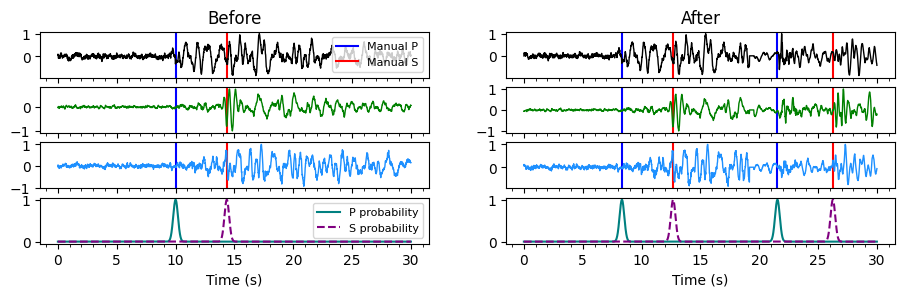

In [312]:
wcolors = ["black", "green", "dodgerblue"]

sample = norm_gen_lp[100]
fig, axs = plt.subplots(4, 2, figsize=(28 * cm, 7 * cm), sharex="all")
plt.subplots_adjust(hspace=0.2)

X_key = "X"
norm_X_key = "Xo"

for i in reversed(range(3)):
    ax = axs[i][0]
    p_picks = get_picks_from_prob(sample["y"][0, :], 0.5)
    s_picks = get_picks_from_prob(sample["y"][1, :], 0.5)
    for p_pick in p_picks[1]:
        ax.axvline(p_pick / 100, color="blue", label="Manual P")
    for s_pick in s_picks[1]:
        ax.axvline(s_pick / 100, color="red", label="Manual S")

    ax.plot(
        np.arange(len(sample[norm_X_key][i, :])) / 100,
        sample[norm_X_key][i, :],
        color=wcolors[i],
        # label=component_order[i],
        lw=1,
    )
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
axs[0][0].legend(fontsize=fts)

labels = ["P probability", "S probability"]
colors = ["teal", "purple"]
lss = ["-", "--"]
for i in range(2):
    axs[3][0].plot(
        np.arange(len(sample["y"][i, :])) / 100,
        sample["y"][i, :],
        lss[i],
        color=colors[i],
        label=labels[i],
    )
axs[3][0].legend(fontsize=fts)

#
sample = sup_gen_lp[100]
for i in reversed(range(3)):
    ax = axs[i][1]
    p_picks = get_picks_from_prob(sample["y"][0, :], 0.5)
    s_picks = get_picks_from_prob(sample["y"][1, :], 0.5)
    for p_pick in p_picks[1]:
        ax.axvline(p_pick / 100, color="blue", label="Manual P")
    for s_pick in s_picks[1]:
        ax.axvline(s_pick / 100, color="red", label="Manual S")

    ax.plot(
        np.arange(len(sample[X_key][i, :])) / 100,
        sample[X_key][i, :],
        color=wcolors[i],
        # label=component_order[i],
        lw=1,
    )
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
# axs[0][1].legend(fontsize=fts)

labels = ["P probability", "S probability"]
colors = ["teal", "purple"]
lss = ["-", "--"]
for i in range(2):
    axs[3][1].plot(
        np.arange(len(sample["y"][i, :])) / 100,
        sample["y"][i, :],
        lss[i],
        color=colors[i],
        label=labels[i],
    )
# axs[3][1].legend(fontsize=fts)

axs[0][0].set_title("Before")
axs[0][1].set_title("After")
for i in range(2):
    axs[-1][i].set_xlabel("Time (s)")
plt.savefig("superimpose.pdf", dpi=600, bbox_inches="tight", pad_inches=0)

In [298]:
sample["y"].shape

(2, 3000)

In [299]:
sample["X"].shape

(3, 3000)

In [240]:
len(y[(0.<y)&(y<0.05)])/len(y)

0.62604

In [27]:
block1 = [
    # In 2/3 of the cases, select windows around picks, to reduce amount of noise traces in training.
    # Uses strategy variable, as padding will be handled by the random window.
    # In 1/3 of the cases, just returns the original trace, to keep diversity high.
    sbg.OneOf(
        [
            sbg.WindowAroundSample(
                list(phase_dict.keys()),
                samples_before=1500,
                windowlen=3000,
                selection="random",
                strategy="pad",
            ),
            sbg.NullAugmentation(),
        ],
        probabilities=[1, 0],
    ),
    sbg.RandomWindow(
        low=None,
        high=None,
        windowlen=1500,
        strategy="pad",
    ),
    sbg.ProbabilisticLabeller(
        label_columns=phase_dict, sigma=20, dim=0, shape="gaussian", noise_column=False
    ),
    detection_labeller,
    # lp_detection_labeller,
    # rg_detection_labeller,
    # Normalize to ensure correct augmentation behavior
    sbg.Normalize(
        detrend_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"
    ),  # "peak"/“std
]

block2 = [
    # In 2/3 of the cases, select windows around picks, to reduce amount of noise traces in training.
    # Uses strategy variable, as padding will be handled by the random window.
    # In 1/3 of the cases, just returns the original trace, to keep diversity high.
    sbg.OneOf(
        [
            sbg.WindowAroundSample(
                list(phase_dict.keys()),
                samples_before=600,
                windowlen=1500,
                selection="random",
                strategy="pad",
            ),
            sbg.NullAugmentation(),
        ],
        probabilities=[1, 0],
    ),
    sbg.RandomWindow(
        low=None,
        high=None,
        windowlen=1500,
        strategy="pad",
    ),
    sbg.ProbabilisticLabeller(
        label_columns=phase_dict, sigma=20, dim=0, shape="gaussian", noise_column=False
    ),
    detection_labeller,
    # lp_detection_labeller,
    # rg_detection_labeller,
    # Normalize to ensure correct augmentation behavior
    sbg.Normalize(
        detrend_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"
    ),  # "peak"/“std
]


second_event_generator = sbg.GenericGenerator(rg_data)
second_event_generator.add_augmentations(block2)

noise_generator = sbg.GenericGenerator(train_data_noise)
noise_generator.add_augmentations(block1)

augmentation_block = [
    sbg.OneOf(
        [
            SuperimposeEvent(
                data_generator=second_event_generator,
                label_columns=phase_dict,
                inv_scale=(1, 1),
                key="X",
                label_key="y",
                # detection_keys=["detections","lp_detections","rg_detections"],
                detection_keys=["detections"],
                sep=200,
                noise_label=False,
                noise_data=False,
            ),
            MyDuplicateEvent(
                label_columns=phase_dict,
                inv_scale=(1, 1),
                key="X",
                label_key="y",
                # detection_keys=["detections","lp_detections","rg_detections"],
                detection_keys=["detections"],
                sep=200,
                noise_label=False,
            ),
            sbg.NullAugmentation(),
        ],
        probabilities=[0, 0, 1],
    ),
    sbg.OneOf(
        [
            SuperimposeEvent(
                data_generator=noise_generator,
                label_columns=phase_dict,
                key="X",
                label_key="y",
                detection_keys=None,
                inv_scale=(10, 10),
                sep=200,
                noise_label=False,
                noise_data=True,
            ),
            sbg.GaussianNoise(),
            sbg.NullAugmentation(),
        ],
        probabilities=[0, 0, 1],
    ),
    # sbg.OneOf(
    #     [SuperimposeEvent(data_generator=second_event_generator,
    #                       label_columns=phase_dict,inv_scale=(1,1),key="X", label_key="y",detection_keys=["lp_detections","rg_detections"],sep=200,noise_label=True, noise_data=False),
    #      MyDuplicateEvent(label_columns=phase_dict,inv_scale=(1,1),key="X",label_key="y",detection_key=None,sep=200,noise_label=True),
    #      sbg.NullAugmentation()],
    #     probabilities=[1,0, 0.2,0.2],
    # ),
    # sbg.AddGap(label_keys=["y", "lp_detections","rg_detections"],noise_id={}),
    sbg.Normalize(detrend_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"),
]

block2 = [
    sbg.ChangeDtype(np.float32, "X"),
    sbg.ChangeDtype(np.float32, "y"),
    # sbg.ChangeDtype(np.float32, "detections"),
]

augmentation = block1 + augmentation_block + block2

In [28]:
x = np.array([[1, 2], [3, 4]])

In [29]:
np.max(x, keepdims=True)

array([[4]])

In [30]:
np.max(x, axis=-1, keepdims=True)

array([[2],
       [4]])

In [31]:
len(noise_generator)

12461

In [32]:
generator1 = sbg.GenericGenerator(lp_data)
generator1.add_augmentations(augmentation)

generator2 = sbg.GenericGenerator(rg_data)
generator2.add_augmentations(augmentation)

generator3 = sbg.GenericGenerator(train_data_noise)
generator3.add_augmentations(augmentation)

In [9]:
sos = signal.butter(4, [2, 20], "bandpass", analog=False, fs=100, output="sos")

In [19]:
sample["X"]

array([[0.02625566, 0.05559588, 0.04102881, ..., 0.2818947 , 0.2895603 ,
        0.3118317 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

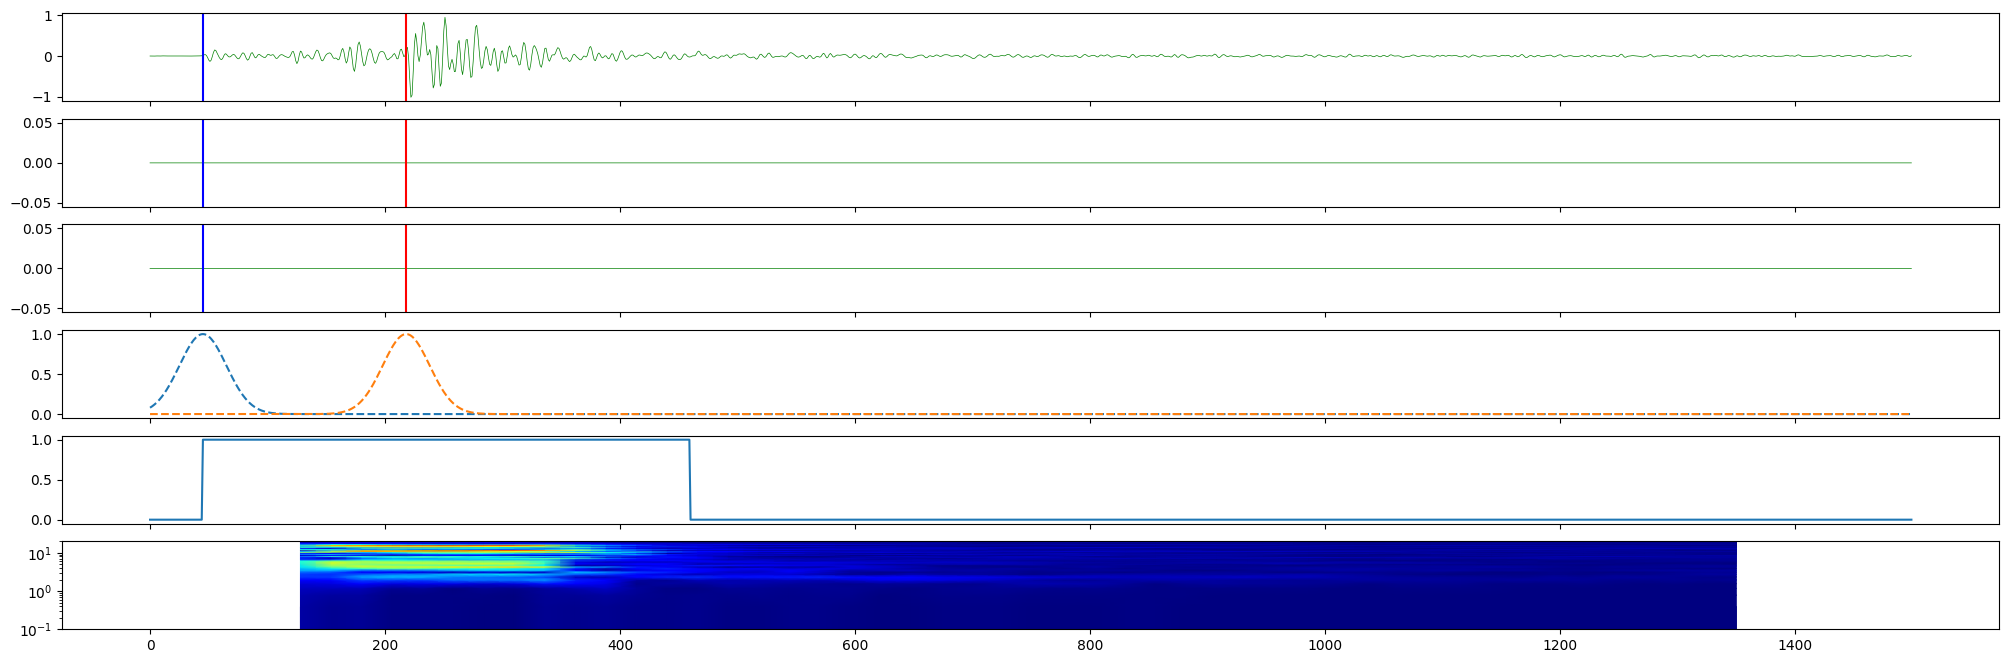

In [48]:
# np.random.seed(198)
sample = generator2[18]  # 320
fig, axs = plt.subplots(6, figsize=(25, 8), sharex="all")
for i in range(3):
    ax = axs[i]
    # ax.plot(sample["X"][i,:].T,color="blue",lw=0.5)
    # sample["X"][i, :] = signal.sosfilt(sos, sample["X"][i, :])
    ax.plot(sample["X"][i, :].T, color="green", lw=0.5)
    # ax.plot(sample["noise"][i,:].T,color="red",lw=0.5)
    # if not np.allclose(sample["y"], 0):
    #     for pred_pick in np.argmax(sample["y"], axis=1):
    #         ax.axvline(pred_pick)
    p_picks = get_picks_from_prob(sample["y"][0, :], 0.5)
    s_picks = get_picks_from_prob(sample["y"][1, :], 0.5)
    for p_pick in p_picks[1]:
        ax.axvline(p_pick, color="blue")
    for s_pick in s_picks[1]:
        ax.axvline(s_pick, color="red")

10
axs[3].plot(sample["y"].T, "--")

axs[4].plot(sample["detections"].T)
# axs[5].plot(sample["lp_detections"].T)
# axs[6].plot(sample["rg_detections"].T)

n_per_segment = 256
n_overlap = int(0.9 * n_per_segment)

f, t, Sxx = signal.spectrogram(
    sample["X"][0, :],
    fs=100,
    mode="magnitude",
    nperseg=n_per_segment,
    noverlap=n_overlap,
)
# axs[6].specgram(sample["X"][0,:])
pm = axs[5].pcolormesh(t * 100, f, Sxx, shading="gouraud", cmap="jet")
axs[5].set_ylim([0.1, 20])
axs[5].set_yscale("log")
# axs[7].set_xlim([400,800])

In [54]:
p_picks = get_picks_from_prob(sample["y"][0, :], 0.5)
s_picks = get_picks_from_prob(sample["y"][1, :], 0.5)

In [55]:
p_picks

(array([1.], dtype=float32), array([1189]))

In [57]:
s_picks

(array([1.], dtype=float32), array([1250]))

In [52]:
np.argmax(sample["y"], axis=1)

array([1189, 1250])

In [32]:
sample["y"]

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 5.0118914e-36,
        2.6460379e-36, 1.3934927e-36]], dtype=float32)

In [908]:
np.max(sample["X"])

1.0

1034 1181


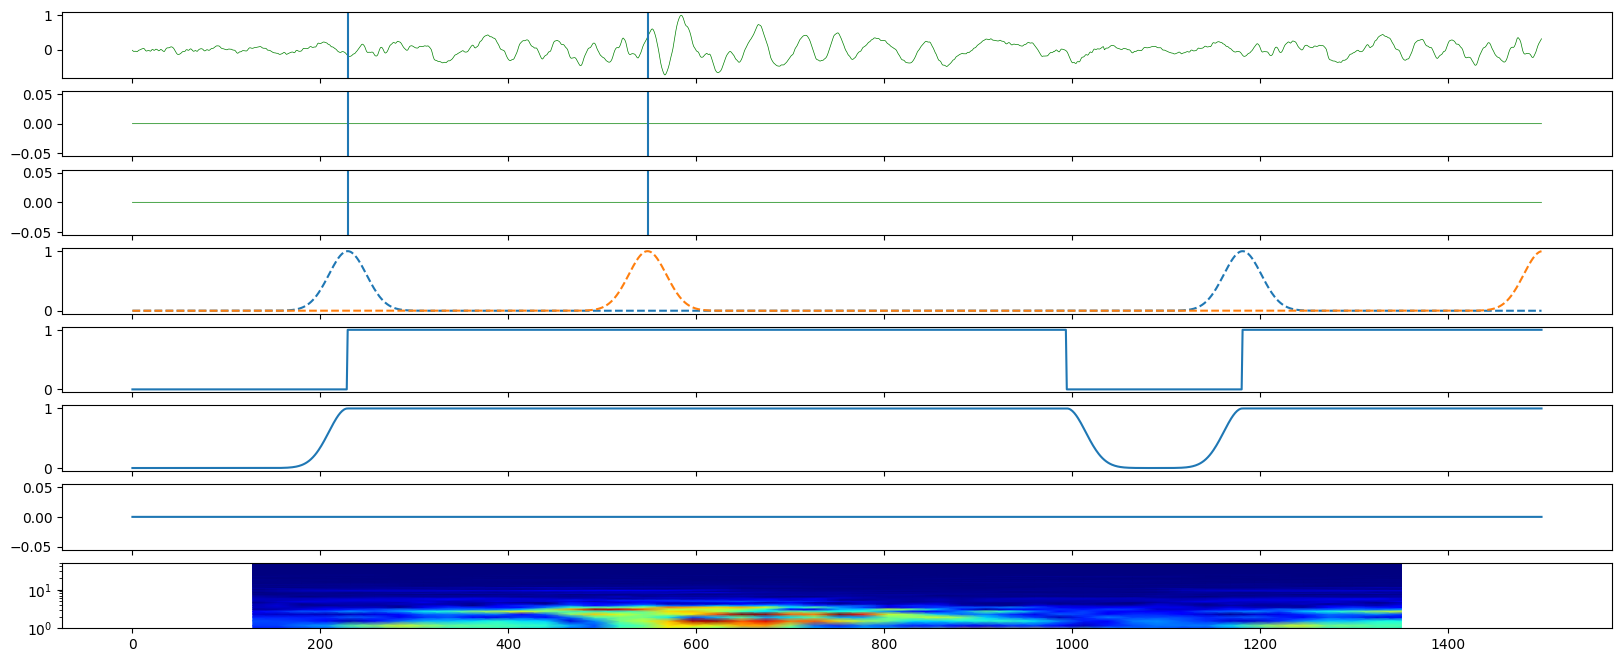

In [902]:
np.random.seed(3)
sample=generator1[200]
fig,axs=plt.subplots(8,figsize=(20,8),sharex="all")
for i in range(3):
    ax=axs[i]
    # ax.plot(sample["X"][i,:].T,color="blue",lw=0.5)
    ax.plot(sample["X"][i,:].T,color="green",lw=0.5)
    for pred_pick in np.argmax(sample["y"],axis=1):
        ax.axvline(pred_pick)
    
10
axs[3].plot(sample["y"].T,"--")

axs[4].plot(sample["detections"].T)
axs[5].plot(sample["lp_detections"].T)
axs[6].plot(sample["rg_detections"].T)

n_per_segment = 256
n_overlap = int(0.9 * n_per_segment)

f, t, Sxx = signal.spectrogram(
    sample["X"][0,:],
    fs=100,
    mode="magnitude",
    nperseg=n_per_segment,
    noverlap=n_overlap,
)
# axs[6].specgram(sample["X"][0,:])
pm = axs[7].pcolormesh(t*100, f, Sxx, shading="gouraud",cmap="jet")
axs[7].set_ylim([1,50])
axs[7].set_yscale("log")
# axs[7].set_xlim([400,800])

In [703]:
x=np.arange(0,0)
y=np.exp(-np.power(x, 2.0) / (2 * np.power(20*0.5, 2.0)))

In [704]:
y

array([], dtype=float64)

In [427]:
x=np.random.randn(5,5)
print(x)

[[ 1.15745829 -0.79624158 -0.10827111 -1.72295965 -1.92959546]
 [ 0.88796088 -1.4676845  -1.35922009 -0.90404996 -0.52460023]
 [ 0.02545221  0.47195759 -0.09121987 -1.60537487  0.01419607]
 [ 2.62540018 -1.56160189 -0.44077696  0.16551597 -0.51092998]
 [-0.75158119 -0.60543426 -2.38140537  0.21358168 -0.04412818]]


In [442]:
x[:,4:]=0

In [443]:
x

array([[ 1.15745829, -0.79624158, -0.10827111, -1.72295965,  0.        ],
       [ 0.88796088, -1.4676845 , -1.35922009, -0.90404996,  0.        ],
       [ 0.02545221,  0.47195759, -0.09121987, -1.60537487,  0.        ],
       [ 2.62540018, -1.56160189, -0.44077696,  0.16551597,  0.        ],
       [-0.75158119, -0.60543426, -2.38140537,  0.21358168,  0.        ]])

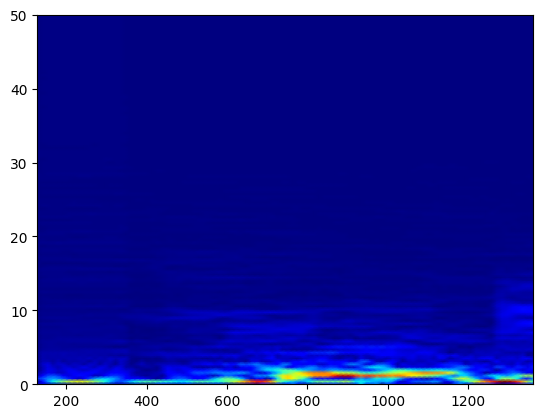

In [78]:
from scipy.fft import fft, fftfreq
from scipy import signal
n_per_segment = 256
n_overlap = int(0.95 * n_per_segment)

f, t, Sxx = signal.spectrogram(
    sample["X"][0,:],
    fs=100,
    mode="magnitude",
    nperseg=n_per_segment,
    noverlap=n_overlap,
)
pm = plt.pcolormesh(t*100, f, Sxx, shading="gouraud", cmap="jet")


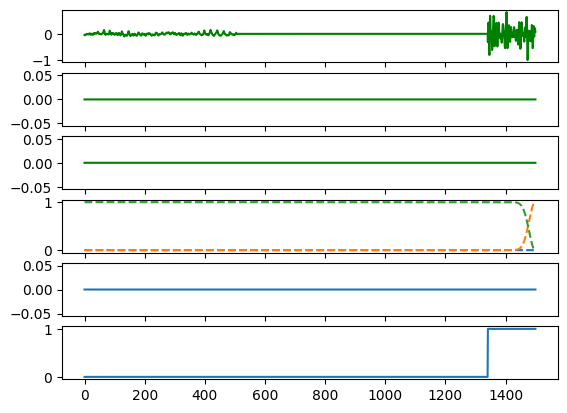

In [40]:
# np.random.seed(120)
sample=generator2[10]
fig,axs=plt.subplots(6,sharex="all")
for i in range(3):
    ax=axs[i]
    ax.plot(sample["X"][i,:].T,color="green")

axs[3].plot(sample["y"].T,"--")    
axs[4].plot(sample["lp_detections"].T)
axs[5].plot(sample["rg_detections"].T)
